# Analyzing Results for Non-Standardized Data

In [1]:
import pandas as pd
import numpy as np
#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
#Statistical Analysis
from numpy.random import seed
from numpy.random import randn
from scipy.stats import friedmanchisquare
#import scikit_posthocs as sp
# Import files
import glob

In [2]:
path = "../Results/Norm/*.csv"
models = []
for fname in glob.glob(path):
    df=pd.read_csv(fname)
    models.append(df)
    my_list=list(df.columns)
    print(len(my_list),my_list)

3 ['folder_name', 'BRM_std_auc', 'BRM_std_avgprecision']
3 ['folder_name', 'GMM_std_auc', 'GMM_std_avgprecision']
3 ['folder_name', 'AVE_Bagging_std_auc', 'AVE_Bagging_std_avgprecision']
3 ['folder_name', 'MCD_std_auc', 'MCD_std_avgprecision']
3 ['folder_name', 'LODA_std_auc', 'LODA_std_avgprecision']
3 ['folder_name', 'OCKRA_std_auc', 'OCKRA_std_avgprecision']
3 ['folder_name', 'HBOS_std_auc', 'HBOS_std_avgprecision']
3 ['folder_name', 'OCSVM_std_auc', 'OCSVM_std_avgprecision']
3 ['folder_name', 'XGBOD_std_auc', 'XGBOD_std_avgprecision']
3 ['folder_name', 'AAD_LMDD_std_auc', 'AAD_LMDD_std_avgprecision']
3 ['folder_name', 'Median_KNN_std_auc', 'Median_KNN_std_avgprecision']
3 ['folder_name', 'LOF_std_auc', 'LOF_std_avgprecision']
3 ['folder_name', 'MAX_Bagging_std_auc', 'MAX_Bagging_std_avgprecision']
3 ['folder_name', 'LSCP_std_auc', 'LSCP_std_avgprecision']
3 ['folder_name', 'COF_std_auc', 'COF_std_avgprecision']
3 ['folder_name', 'IQR_LMDD_std_auc', 'IQR_LMDD_std_avgprecision']
3 ['

In [3]:
# Separate AUC and Precision 
from functools import reduce
def separate_performance(models):
    join_models = pd.concat(
    (dataframe.set_index('folder_name') for dataframe in models),
    axis=1, join='inner' ).reset_index()
    auc_df = join_models.loc[:, join_models.columns.str.endswith('auc')]
    avg_prec_df = join_models.loc[:, join_models.columns.str.endswith('avgprecision')]
    return join_models, auc_df,avg_prec_df

In [4]:
join_models,df_auc,df_avg_precision  = separate_performance(models)

In [5]:
models_names = df_auc.columns.tolist()
models_names = [i.rstrip('_std_auc') for i in models_names]

In [6]:
dataset_names = join_models['folder_name']

In [7]:
# Plot Performance Metrics
def plot_metrics(df, title = 'Classifiers AUC Evaluation', y_label = 'AUC', list_names =[]):
    plt.figure(figsize=(25, 20))
    box = plt.boxplot(df,
                patch_artist=True, # to fill with color
                notch='True', # notch shape
                labels=list_names) # the labels to use
    plt.title(title, fontsize=25)
    plt.ylabel(y_label, fontsize=20)
    plt.xticks(rotation=90, fontsize = 15)
    plt.yticks(fontsize = 15)
    # fill with different colors
    colors = ['blue', 'orchid','peru', 'green', 'teal','wheat','red', 'indigo', 'brown', 'pink',
                'grey','magenta','limegreen','lightsteelblue','royalblue','navy','slateblue','aquamarine','tan','lightcoral',
                'salmon','khaki','darkslategray','lawngreen','purple','azure','darkseagreen','rosybrown','orange']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    return plt.show()

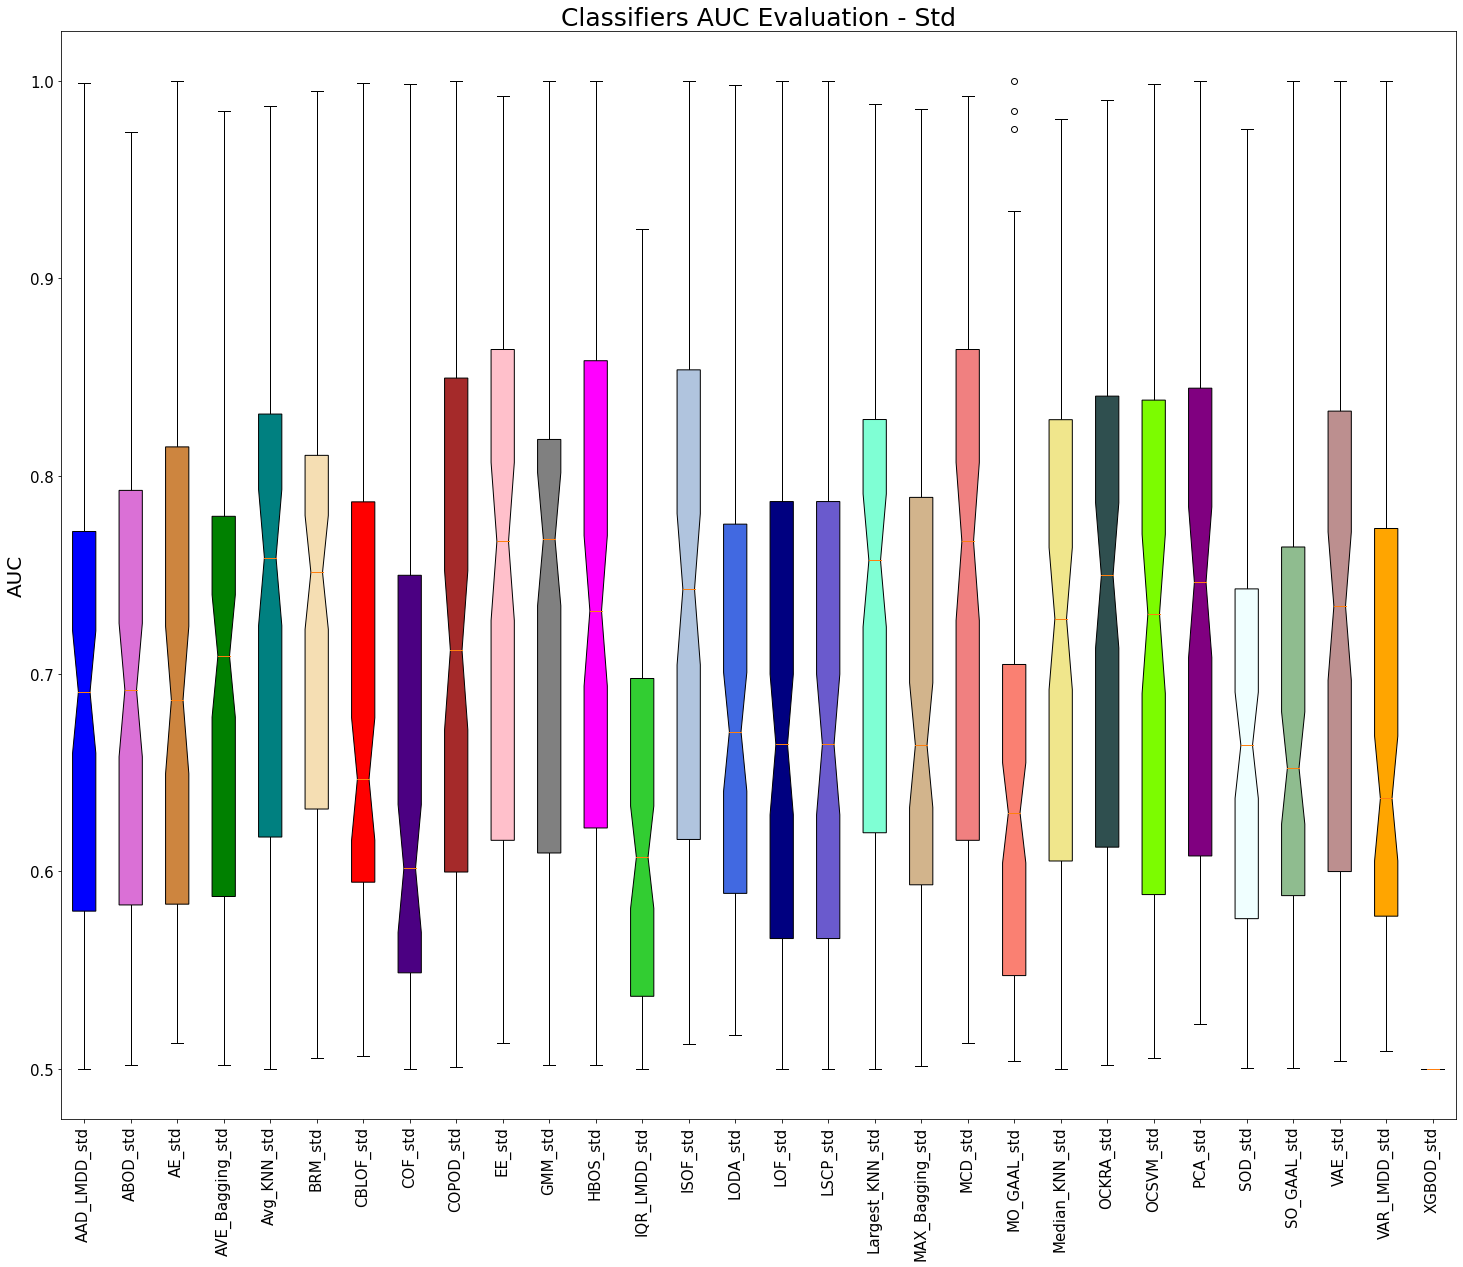

In [8]:
df_auc2 = df_auc.reindex(sorted(df_auc.columns), axis=1)
plot_metrics(df_auc2,title = 'Classifiers AUC Evaluation - Std', y_label = 'AUC', list_names =[i.rstrip('_mm_auc') for i in df_auc2.columns.tolist()])

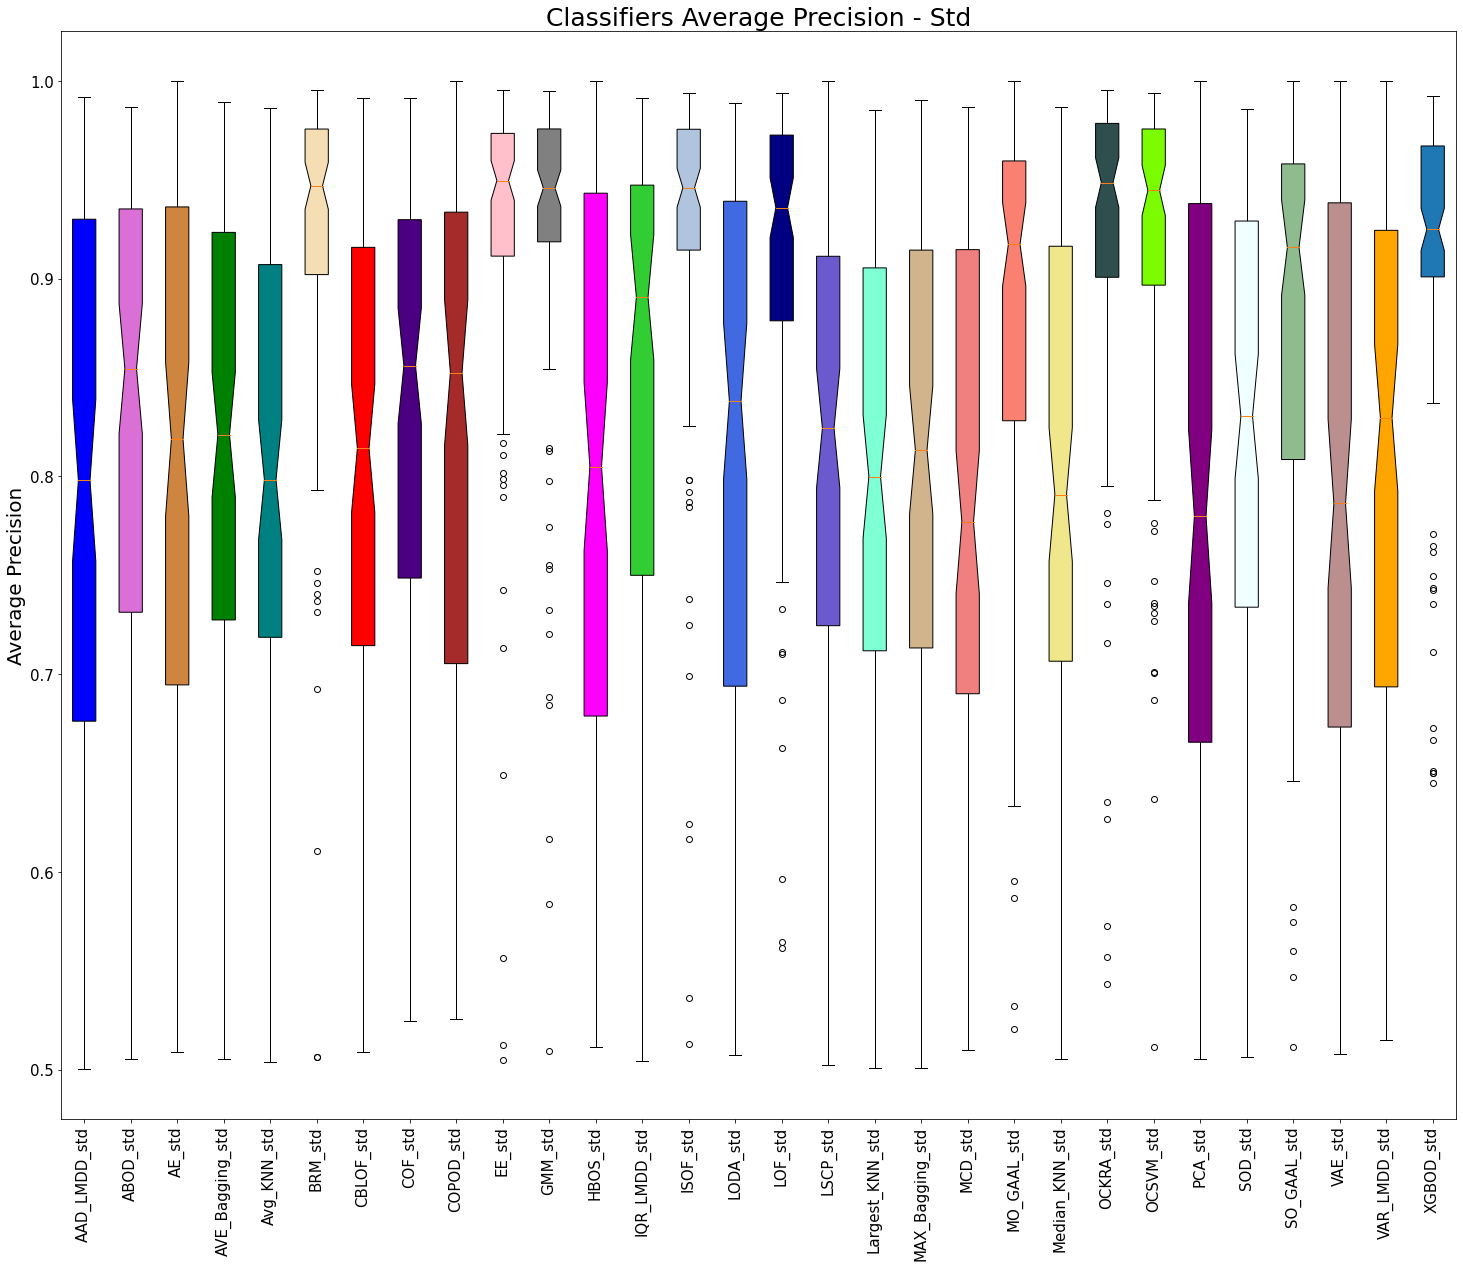

In [9]:
df_avg_precision2 = df_avg_precision.reindex(sorted(df_avg_precision.columns), axis=1)
plot_metrics(df_avg_precision2 , 'Classifiers Average Precision - Std' , 'Average Precision' , list_names =[i.rstrip('_mm_avgprecision') for i in df_avg_precision2.columns.tolist()])


In [10]:
mean_auc = df_auc.mean()

In [11]:
mean_avg = df_avg_precision.mean()

In [12]:
# Save the object in a python file
import pickle
with open('std_mean_auc.data','wb') as data:
    pickle.dump(mean_auc, data)
with open('std_mean_avg.data','wb') as data:
    pickle.dump(mean_avg, data)

# Hypothesis Testing

Comparing multiple classifiers over multiple datasets

In [13]:
#pip install Orange3
#pip install scipy
#pip install autorank

In [14]:
from scipy.stats import friedmanchisquare , rankdata
from Orange.evaluation import compute_CD, graph_ranks
from autorank import autorank, plot_stats, create_report, latex_table

In [15]:
# dataset names
df_auc['dataset_names'] = dataset_names
df_avg_precision['dataset_names'] = dataset_names
# algorithms names
algorithms_names_auc =df_auc.drop('dataset_names', axis=1).columns
algorithms_names_avg =df_avg_precision.drop('dataset_names', axis=1).columns

In [16]:
performances_array = df_auc[algorithms_names_auc].values
# Finally, we apply the Friedman test.
friedmanchisquare(*performances_array)

FriedmanchisquareResult(statistic=1450.341480638384, pvalue=8.520204526400224e-242)

In [17]:
def friedman_test(*args):
    stat, p = friedmanchisquare(*args)
    print('Statistics=%.3f, p=%.4E' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        return 'Fail to reject H0'
    else:
	    return 'Reject H0'

In [18]:
# For AUC
*a, = [df_auc.iloc[:,i] for i in range(len(df_auc.drop('dataset_names', axis=1).columns))]
a_np = np.array(a) # Here the columns correspond to the blocking factor (datasets) and the rows to the algorithms
a_np = a_np.T # Here the rows correspond to the blocking factor (datasets) and the columns correspond to the primary factor (algorithms)
friedman_test(*a_np)

Statistics=1450.341, p=8.5202E-242


'Reject H0'

In [19]:
# For Average Precision
*b, = [df_avg_precision.iloc[:,i] for i in range(len(df_avg_precision.drop('dataset_names', axis=1).columns))]
b_np = np.array(b) # Here the columns correspond to the blocking factor (datasets) and the rows to the algorithms
b_np = b_np.T # Here the rows correspond to the blocking factor (datasets) and the columns correspond to the primary factor (algorithms)
friedman_test(*b_np)

Statistics=1729.785, p=5.8254E-299


'Reject H0'

## Rankings 

In [20]:
ranks_auc = np.array([rankdata(-p) for p in a_np])
ranks_avg_precision = np.array([rankdata(-p) for p in b_np])

In [21]:
ranks_auc_df = pd.DataFrame(ranks_auc, columns = algorithms_names_auc)

In [22]:
ranks_avg_precision_df = pd.DataFrame(ranks_avg_precision, columns = algorithms_names_avg)

In [23]:
# Calculating the average ranks.
average_ranks_auc = np.average(ranks_auc, axis=0)
print('\n'.join('{} average rank: {}'.format(a, r) for a, r in zip(algorithms_names_auc, average_ranks_auc)))

BRM_std_auc average rank: 12.710526315789474
GMM_std_auc average rank: 12.726315789473684
AVE_Bagging_std_auc average rank: 16.44736842105263
MCD_std_auc average rank: 10.91578947368421
LODA_std_auc average rank: 16.094736842105263
OCKRA_std_auc average rank: 12.23157894736842
HBOS_std_auc average rank: 12.705263157894738
OCSVM_std_auc average rank: 13.43157894736842
XGBOD_std_auc average rank: 29.905263157894737
AAD_LMDD_std_auc average rank: 16.07894736842105
Median_KNN_std_auc average rank: 12.705263157894738
LOF_std_auc average rank: 17.24736842105263
MAX_Bagging_std_auc average rank: 16.757894736842104
LSCP_std_auc average rank: 17.242105263157896
COF_std_auc average rank: 20.18421052631579
IQR_LMDD_std_auc average rank: 20.96842105263158
VAE_std_auc average rank: 13.33157894736842
CBLOF_std_auc average rank: 16.542105263157893
MO_GAAL_std_auc average rank: 19.710526315789473
SOD_std_auc average rank: 18.63684210526316
ABOD_std_auc average rank: 17.31578947368421
SO_GAAL_std_auc a

In [24]:
result_auc = autorank(df_auc.drop('dataset_names',axis = 1), alpha=0.05, verbose=False)
print(result_auc)

RankResult(rankdf=
                      meanrank    median        mad  ci_lower  ci_upper  \
EE_std_auc           10.889474  0.766938   0.180515  0.628221  0.863778   
MCD_std_auc          10.915789  0.766938   0.180515  0.628221  0.863778   
Avg_KNN_std_auc      11.347368    0.7588   0.138805  0.628001  0.831364   
Largest_KNN_std_auc  11.557895  0.757359   0.145804   0.62609  0.824828   
ISOF_std_auc         11.715789  0.742757   0.174818  0.625719  0.852462   
PCA_std_auc          11.936842   0.74633    0.17931  0.627227  0.840511   
OCKRA_std_auc        12.231579  0.749775    0.17375  0.622844  0.837474   
HBOS_std_auc         12.705263  0.731846   0.185183  0.632173   0.85675   
Median_KNN_std_auc   12.705263  0.727927   0.157188  0.621904  0.826081   
BRM_std_auc          12.710526  0.751283   0.133723  0.636877  0.809341   
GMM_std_auc          12.726316  0.768098   0.165676  0.614718  0.816143   
VAE_std_auc          13.331579  0.734234   0.179162  0.606199  0.832577   
COPOD_

In [25]:
#algorithms_names_auc = [i.rstrip('_std_auc') for i in algorithms_names_auc]
#algorithms_names_avg = [i.rstrip('_std_avg_precision') for i in algorithms_names_avg]

In [26]:
create_report(result_auc)
#latex_table(result_auc)

The statistical analysis was conducted for 30 populations with 95 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations Largest_KNN_std_auc (p=0.001), ISOF_std_auc (p=0.001), PCA_std_auc (p=0.001), HBOS_std_auc (p=0.001), BRM_std_auc (p=0.001), VAE_std_auc (p=0.000), OCSVM_std_auc (p=0.000), AE_std_auc (p=0.000), AAD_LMDD_std_auc (p=0.000), AVE_Bagging_std_auc (p=0.000), CBLOF_std_auc (p=0.000), SO_GAAL_std_auc (p=0.000), MAX_Bagging_std_auc (p=0.001), LSCP_std_auc (p=0.000), LOF_std_auc (p=0.000), ABOD_std_auc (p=0.001), MO_GAAL_std_auc (p=0.001), COF_std_auc (p=0.000), and IQR_LMDD_std_auc (p=0.001). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median 

In [56]:
df_ranking_avg_auc = pd.DataFrame(average_ranks_auc, index = algorithms_names_auc)
df_ranking_avg_auc.columns = ['auc']
df_ranking_avg_avgprecision = pd.DataFrame(average_ranks_avg_precision, index = algorithms_names_avg)
df_ranking_avg_avgprecision.columns = ['average_precision']

In [57]:
# Calculating the average ranks.
average_ranks_avg_precision = np.average(ranks_avg_precision, axis=0)
print('\n'.join('{} average rank: {}'.format(a, r) for a, r in zip(algorithms_names_avg, average_ranks_avg_precision)))

BRM average rank: 7.578947368421052
GMM average rank: 7.073684210526316
AVE_Bagging average rank: 18.8
MCD average rank: 20.18421052631579
LODA average rank: 17.221052631578946
OCKRA average rank: 7.431578947368421
HBOS average rank: 17.910526315789475
OCSVM average rank: 8.536842105263158
XGBOD average rank: 10.678947368421053
AAD_LMDD average rank: 19.478947368421053
Median_KNN average rank: 20.46315789473684
LOF average rank: 9.884210526315789
MAX_Bagging average rank: 19.03157894736842
LSCP average rank: 18.757894736842104
COF average rank: 17.210526315789473
IQR_LMDD average rank: 16.04736842105263
VAE average rank: 19.24736842105263
CBLOF average rank: 18.96842105263158
MO_GAAL average rank: 12.647368421052631
SOD average rank: 18.36842105263158
ABOD average rank: 17.563157894736843
SO_GAAL average rank: 12.857894736842105
AE average rank: 17.657894736842106
PCA average rank: 19.4
Largest_KNN average rank: 20.778947368421054
Avg_KNN average rank: 20.857894736842105
COPOD average 

In [58]:
result_avg = autorank(df_avg_precision.drop('dataset_names',axis = 1), alpha=0.05, verbose=False)
print(result_avg)

RankResult(rankdf=
                               meanrank    median        mad  ci_lower  \
EE_std_avgprecision            6.889474   0.94955  0.0390139   0.91713   
GMM_std_avgprecision           7.073684  0.945715  0.0433944  0.920383   
OCKRA_std_avgprecision         7.431579  0.948512  0.0479902  0.919738   
BRM_std_avgprecision           7.578947  0.946894  0.0470646  0.904356   
ISOF_std_avgprecision          8.010526  0.945884  0.0447673  0.919056   
OCSVM_std_avgprecision         8.536842  0.944553  0.0501039  0.903282   
LOF_std_avgprecision           9.884211   0.93584  0.0585959  0.899915   
XGBOD_std_avgprecision        10.678947  0.924855  0.0556402  0.901163   
MO_GAAL_std_avgprecision      12.647368  0.917302  0.0768141  0.845126   
SO_GAAL_std_avgprecision      12.857895  0.915717  0.0883633  0.816847   
IQR_LMDD_std_avgprecision     16.047368  0.890571   0.106471  0.763382   
COF_std_avgprecision          17.210526   0.85587   0.129035  0.764529   
LODA_std_avgprecisi

In [59]:
create_report(result_avg)
#latex_table(result_avg)

The statistical analysis was conducted for 30 populations with 95 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations EE_std_avgprecision (p=0.000), GMM_std_avgprecision (p=0.000), OCKRA_std_avgprecision (p=0.000), BRM_std_avgprecision (p=0.000), ISOF_std_avgprecision (p=0.000), OCSVM_std_avgprecision (p=0.000), LOF_std_avgprecision (p=0.000), XGBOD_std_avgprecision (p=0.000), MO_GAAL_std_avgprecision (p=0.000), SO_GAAL_std_avgprecision (p=0.000), IQR_LMDD_std_avgprecision (p=0.000), COF_std_avgprecision (p=0.000), LODA_std_avgprecision (p=0.000), COPOD_std_avgprecision (p=0.001), ABOD_std_avgprecision (p=0.000), AE_std_avgprecision (p=0.000), HBOS_std_avgprecision (p=0.000), VAR_LMDD_std_avgprecision (p=0.000), SOD_std_avgprecision (p=0.000), LSCP_std_avgprecision (p=0.000), AVE_Bagging_std_avgprecision (p=0.000), CBLOF_std_avgprecision (p=0.000), MAX_Bagging_std_avgprecision 

In [60]:
import scikit_posthocs as sp
blocks = sp.__convert_to_block_df(a_np)
blocks

(      blocks groups         y
 0          0      0  0.841478
 1          1      0  0.631977
 2          2      0  0.840151
 3          3      0  0.938020
 4          4      0  0.724298
 ...      ...    ...       ...
 2845      90     29  0.582808
 2846      91     29  0.690407
 2847      92     29  0.871780
 2848      93     29  0.731559
 2849      94     29  0.714583
 
 [2850 rows x 3 columns],
 'y',
 'groups',
 'blocks')

## Post-Hoc Evaluation

In [61]:
# Post-hoc analysis

from scikit_posthocs import posthoc_nemenyi_friedman as nemenyi
import scipy as sp
import scipy.stats as st
import itertools as it
import sys
sys.path.append('/Volumes/GoogleDrive/My Drive/MCCNotes/Jlab projects/GITHUB_repositories/Clones/stac/stac/')
# Or you could import the module as a whole,
#from nonparametric_tests import shaffer_multitest,friedman_test,nemenyi_multitest

In [62]:
ev_auc = df_auc.drop('dataset_names',axis = 1).copy()
ev_avg = df_avg_precision.drop('dataset_names', axis = 1).copy()
ev_auc.columns = [i.rstrip('_std_auc') for i in ev_auc.columns]
ev_avg.columns = [i.rstrip('_std_avgprecision') for i in ev_avg.columns ]

In [63]:
ny_auc = nemenyi(ev_auc)

Text(0.5, 1.0, 'AUC Signifcant Difference with Nemenyi - Std')

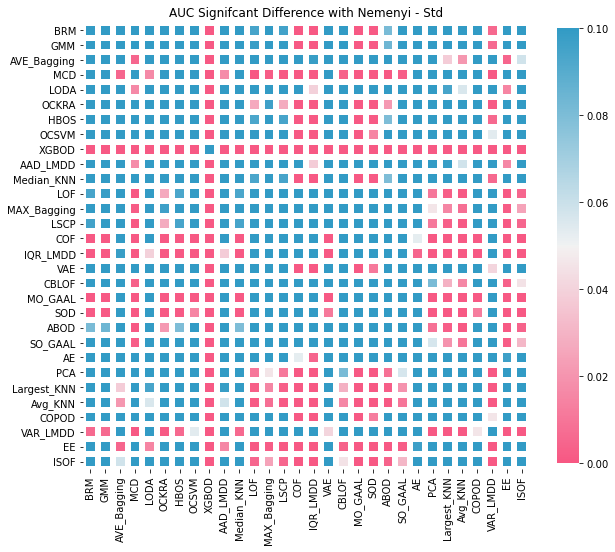

In [64]:
plt.figure(figsize=(10, 10))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
ax = sns.heatmap(ny_auc, annot=False, fmt=".1f", 
           linewidths=5, cmap=cmap, vmin=0, vmax=0.1, 
           cbar_kws={"shrink": .8}, square=True)
plt.title('AUC Signifcant Difference with Nemenyi - Std')

In [65]:
ny_avg = nemenyi(ev_avg)


Text(0.5, 1.0, 'Average Precision Signifcant Difference with Nemenyi -Std')

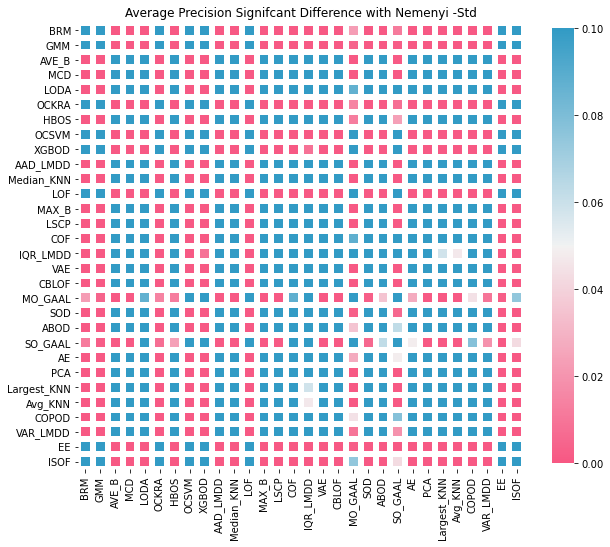

In [66]:
plt.figure(figsize=(10, 10))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
ax = sns.heatmap(ny_avg, annot=False, fmt=".1f", 
           linewidths=5, cmap=cmap, vmin=0, vmax=0.1, 
           cbar_kws={"shrink": .8}, square=True)
plt.title('Average Precision Signifcant Difference with Nemenyi -Std')

## CD Diagram

In [67]:
def compute_CD_diagram(cd , ranks,metric ,names):
    # Critical difference for Nemenyi test with alpha=0.05.
    graph_ranks(ranks,
    names=names,
    cd=cd,
    width=10,
    textspace=1.5,
    reverse=True)
    title = str(metric) + ' CD Diagram for Nemenyi Test - Std'
    plt.title(title)
    plt.show()
    # Critical difference for Bonferroni-Dunn test with alpha=0.05.
    graph_ranks(ranks,
    names=names,
    cd=cd,
    cdmethod=0,
    width=10,
    textspace=1.5,
    reverse=True)
    plt.title(str(metric)  +' CD Diagram for Bonferroni-Dunn Test - Std')
    plt.show()

In [68]:
cd_auc1= compute_CD(average_ranks_auc[0:20],
n=len(df_auc.iloc[:,0:20]),
alpha='0.05',
test='nemenyi')

In [69]:
cd_auc1

3.0419796093784752

In [70]:
algorithms_names_auc = [i.rstrip('_std_auc') for i in algorithms_names_auc]

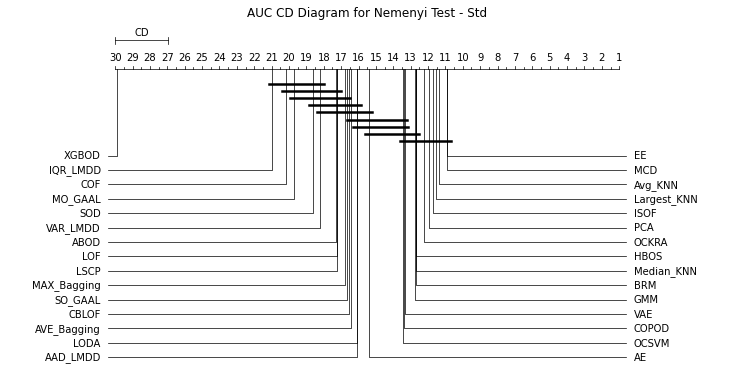

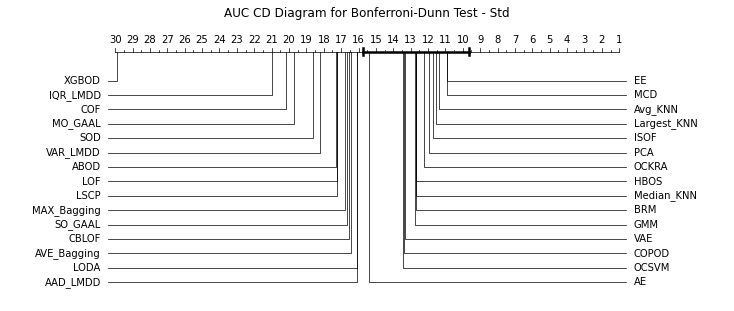

In [71]:
compute_CD_diagram(cd_auc1,average_ranks_auc, 'AUC', algorithms_names_auc)

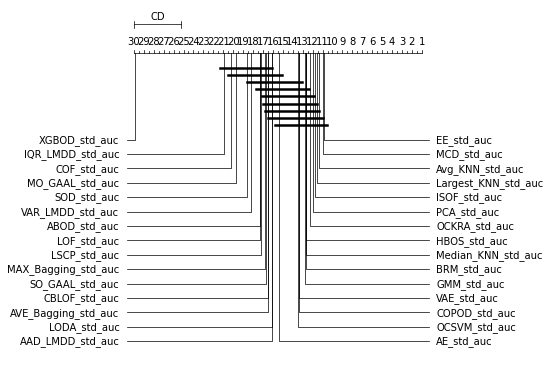

In [72]:
plot_stats(result_auc)
plt.show()

In [73]:
algorithms_names_avg  = [i[:-17] for i in algorithms_names_avg]

In [74]:
cd_avg1= compute_CD(average_ranks_avg_precision[0:20],
n=len(df_avg_precision.iloc[:,0:20]),
alpha='0.05',
test='nemenyi')

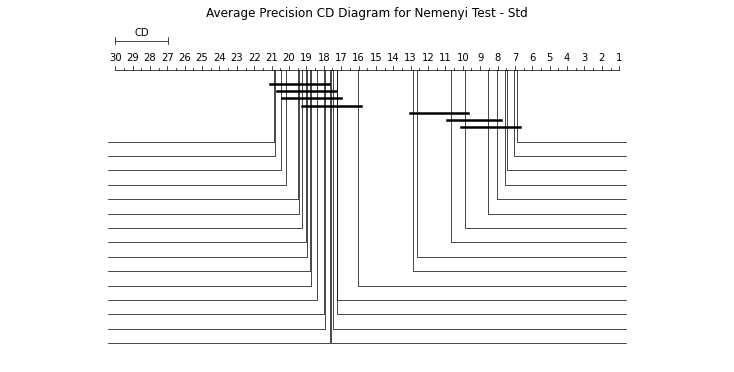

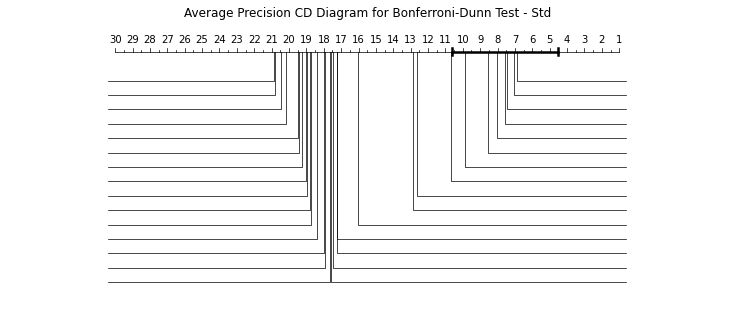

In [75]:
compute_CD_diagram(cd_avg1,average_ranks_avg_precision, 'Average Precision', algorithms_names_avg)

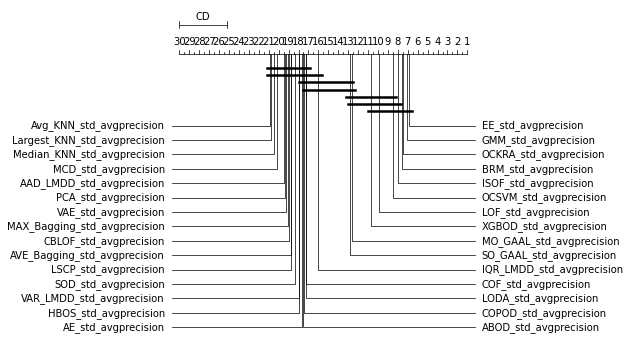

In [76]:
plot_stats(result_avg)
plt.show()

## 2D Diagram|

In [77]:
#pip install adjustText

In [78]:
import random
from adjustText import adjust_text
def plot_2d(df, title = "One-Class Classifiers' Rank - Std"):
    # Create layer for 2D Graph
    fig = plt.figure(figsize = (20,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Average Ranking for AUC', fontsize = 15)
    ax.set_ylabel('Averange Ranking for Average Precision', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    # Plot
    targets = df['algorithm'].unique()
    x=np.linspace(0,int(np.max(df.average_precision) +2))
    line = ax.plot(x,x,'g-') # identity line
    ax = sns.scatterplot(x = 'auc', y = 'average_precision' , hue = 'algorithm', data = df, s= 1000, alpha = 0.5, palette = 'muted')
    # zip joins x and y coordinates in pairs
    xs = df['auc']
    ys = df['average_precision']

    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(frameon=True, fontsize = 10)
    texts = [plt.text(xs[i], ys[i], '%s' %targets[i], ha='center', va='center' , fontsize = 12) for i in range(len(xs))]
    adjust_text(texts)
    plt.show()

    return None

In [80]:
#df_ranking_avg_auc.index  = [i.rstrip('_auc') for i in df_ranking_avg_auc.index ]
#df_ranking_avg_avgprecision.index  = [i[:-13] for i in df_ranking_avg_avgprecision.index ]
df_rank_avg = pd.concat([df_ranking_avg_auc, df_ranking_avg_avgprecision], axis = 1)

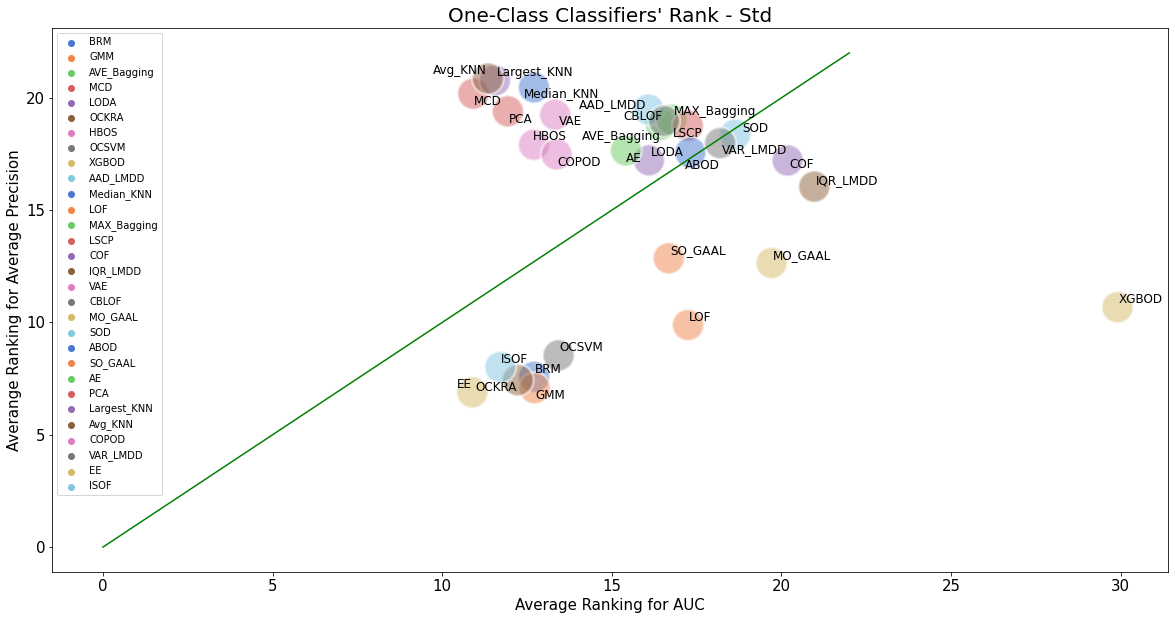

In [81]:
plot_2d(df_rank_avg.reset_index().rename(columns={'index':'algorithm'}))